In [1]:
# Instagram Influencers Analysis
![Influencer](https://newsfeed.org/wp-content/uploads/Instagram-Influencer-marketing-tutorial.jpg)

/bin/bash: -c: line 0: syntax error near unexpected token `https://newsfeed.org/wp-content/uploads/Instagram-Influencer-marketing-tutorial.jpg'
/bin/bash: -c: line 0: `[Influencer](https://newsfeed.org/wp-content/uploads/Instagram-Influencer-marketing-tutorial.jpg)'


## Context
* Instagram is one of the most popular social media websites with about 1 billion active users. 
* Instagram marketing has proliferated as a source for companies to market their products with one way known as Brand-sponsored post.
* This involves Instagram users known as "Influencers" to post about a brand or particular product in exchange for a fee/gift for the post.

**This project aims to identify whether a post is sponsored, who the sponsor is and develop a Recommender System.**

In [2]:
!pip install pytrends
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
import spacy
import re
from pytrends.request import TrendReq
import datetime
import emoji
import time
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
init_notebook_mode(connected=True)

pd.set_option('display.max_rows', 500)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
influencers_raw = pd.read_csv("../input/influencers-post/influencers.csv",encoding='ISO 8859-1')
orgcorpus_raw = pd.read_csv("../input/influencers-post/orgcorpus.txt", sep=",", header=None).values.tolist()[0]

influencers_raw.head()
influencers_raw.describe()

,id,User,Followers,Postdate,Likes,Comments,Caption,Industry,Country
0,1,alinagavrilov_,101622.0,24/11/2021 3:26,857.0,15,Layered neutrals Ã°Å¸âÂ¤ who else has been l...,Fashion,United States
1,2,alinagavrilov_,101622.0,21/11/2021 21:21,576.0,34,When in doubt Ã°Å¸Â¤Å½ @mango has been killing...,Fashion,United States
2,3,alinagavrilov_,101622.0,16/11/2021 2:13,937.0,32,Back to my classic combo Ã°Å¸Â¤Å½ linking some...,Fashion,United States
3,4,alinagavrilov_,101622.0,15/11/2021 1:30,1097.0,54,Pop of Ã°Å¸Â§Â¡ to match the Ã°Å¸ÂÂÃ°Å¸Ââ...,Fashion,United States
4,5,alinagavrilov_,101622.0,13/11/2021 18:04,383.0,28,Sweater vest club Ã°Å¸ÂâÃ°Å¸ÂÂ happy Satu...,Fashion,United States


,id,Followers,Likes,Comments
count,2578.000000,2.568000e+03,2523.000000,2578.000000
mean,1295.193949,1.989145e+05,5214.910028,79.804112
std,746.191971,2.567473e+05,21804.761292,562.743575
min,1.000000,6.420000e+02,-1.000000,0.000000
25%,652.250000,2.752000e+04,304.000000,7.000000
50%,1296.500000,9.784050e+04,1060.000000,20.000000
75%,1940.750000,2.889060e+05,3961.500000,50.000000
max,2585.000000,2.477901e+06,595464.000000,20310.000000


## 1. Exploratory Data Analysis

### 1.1 Data Cleaning

**Check Unique Columns and DataTypes**

In [4]:
influencers_raw['User'].nunique()
influencers_raw['Industry'].nunique()
influencers_raw['Country'].nunique()

influencers_raw.dtypes

465

34

28

id             int64
User          object
Followers    float64
Postdate      object
Likes        float64
Comments       int64
Caption       object
Industry      object
Country       object
dtype: object

**Check for Missing Values**

In [5]:
influencers_raw.isnull().values.any()
print('There are ' + str(influencers_raw['User'].isnull().sum()) + ' missing values in User column.')
print('There are ' + str(influencers_raw['Industry'].isnull().sum()) + ' missing values in Industry column.')
print('There are ' + str(influencers_raw['Country'].isnull().sum()) + ' missing values in Country column.')
print('There are ' + str(influencers_raw['Caption'].isnull().sum()) + ' missing values in Caption column.')

True

There are 5 missing values in User column.
There are 378 missing values in Industry column.
There are 0 missing values in Country column.
There are 52 missing values in Caption column.


**Replace missing values in Industry column as "General"**

In [6]:
inf_df = influencers_raw.copy()
inf_df['Industry'] = inf_df['Industry'].fillna('General')

**Drop all NA on Caption Column**
* As we are finding if a post is sponsored or not, posts' with no caption will serve us no purpose.

In [7]:
inf_df = inf_df[inf_df['Caption'].notna()]

**Check for Duplicates/Re-entries**

In [8]:
inf_df['Caption'].duplicated().any()

inf_df[inf_df.duplicated(subset=['User','Caption','Postdate'], keep=False)].head(5)

True

,id,User,Followers,Postdate,Likes,Comments,Caption,Industry,Country
943,951,evanmenswear,17846.0,24/10/2019 10:59,407.0,1,Letâs get inspired by our comfy looks. We al...,Fashion,Netherlands
944,952,evanmenswear,17846.0,24/10/2019 10:59,854.0,0,Letâs get inspired by our comfy looks. We al...,Fashion,Netherlands
1105,1113,peddey_,57593.0,25/11/2021 14:15,4106.0,2,Reklame || @itsmay.dk holder black friday klok...,General,Denmark
1106,1114,peddey_,57593.0,23/11/2021 15:10,5680.0,1365,Reklame || Det er tid til en GIVEAWAY!ð\n\n...,General,Denmark
1107,1115,peddey_,57593.0,20/11/2021 15:33,4359.0,9,Reklame for @tisedenmark || Tise er en app hvo...,General,Denmark


**Drop Duplicates**

In [9]:
inf_df = inf_df.drop_duplicates(['User','Caption','Postdate'],keep= 'last')

**Convert Postdate to datetime format from object**

In [10]:
inf_df['Postdate'] = pd.to_datetime(inf_df['Postdate'])
# Set Postdate as index
inf_df = inf_df.set_index('Postdate')

### 1.2 Feature Engineering

In [11]:
inf_df['Engagement Rate'] = ((inf_df['Comments']+inf_df['Likes'])/inf_df['Followers'])*100
inf_df
inf_df.describe()
#Drop column id
inf_df.drop('id', axis=1, inplace=True)

,id,User,Followers,Likes,Comments,Caption,Industry,Country,Engagement Rate
Postdate,,,,,,,,,
2021-11-24 03:26:00,1,alinagavrilov_,101622.0,857.0,15,Layered neutrals Ã°Å¸âÂ¤ who else has been l...,Fashion,United States,0.858082
2021-11-21 21:21:00,2,alinagavrilov_,101622.0,576.0,34,When in doubt Ã°Å¸Â¤Å½ @mango has been killing...,Fashion,United States,0.600264
2021-11-16 02:13:00,3,alinagavrilov_,101622.0,937.0,32,Back to my classic combo Ã°Å¸Â¤Å½ linking some...,Fashion,United States,0.953534
2021-11-15 01:30:00,4,alinagavrilov_,101622.0,1097.0,54,Pop of Ã°Å¸Â§Â¡ to match the Ã°Å¸ÂÂÃ°Å¸Ââ...,Fashion,United States,1.132629
2021-11-13 18:04:00,5,alinagavrilov_,101622.0,383.0,28,Sweater vest club Ã°Å¸ÂâÃ°Å¸ÂÂ happy Satu...,Fashion,United States,0.404440
...,...,...,...,...,...,...,...,...,...
2021-11-24 23:37:00,2581,edi.bee,99776.0,381.0,2,Little love,Travel,Australia,0.383860
2021-11-24 10:20:00,2582,edi.bee,99776.0,1483.0,20,The close up nobody asked for ð¦ð¦,Travel,Australia,1.506374
2021-11-24 10:06:00,2583,edi.bee,99776.0,1891.0,36,Soft sands ð¦ @tigerlily swim ð¦ð,Travel,Australia,1.931326


,id,Followers,Likes,Comments,Engagement Rate
count,2481.000000,2.471000e+03,2426.000000,2481.000000,2416.000000
mean,1297.870617,2.040990e+05,5362.120363,80.694075,3.080975
std,753.067651,2.593975e+05,22177.330087,572.291596,4.865254
min,1.000000,6.420000e+02,-1.000000,0.000000,-0.000771
25%,641.000000,2.838250e+04,331.750000,7.000000,0.626529
50%,1316.000000,1.032310e+05,1122.000000,21.000000,1.598521
75%,1952.000000,3.005780e+05,4071.750000,52.000000,3.593291
max,2585.000000,2.477901e+06,595464.000000,20310.000000,70.779697


### Identifying Sponsored Posts with Natural Language Processing

In [12]:
# Load NLP model
nlp = spacy.load('en_core_web_lg')
stop_words = set(stopwords.words("english"))

**Clean and Tokenize Caption**

In [13]:
def tokens(list_words):
    nonTokenWords = []
    for i in list_words:
        if ((str(i).lower() not in stop_words and str(i).isalnum()) and bool(re.match('^[a-zA-Z0-9]+$', str(i))))  or "@" in str(i):
            nonTokenWords.append(str(i).lower())
    return nonTokenWords

inf_df['segment_caption'] = inf_df.apply(lambda row: nlp(str(row.Caption)) , axis=1)
inf_df['clean_caption'] = inf_df.apply(lambda row: tokens(row.segment_caption) ,axis=1)

**Get Possible Sponsor(At Sign - Tagging & Entity/Org identification)**

In [14]:
def remove_emoji(string, boo):
           #text = text.decode()
            #text = emoji.get_emoji_regexp().sub(u'', text)
            #text = re.sub(r'[^\x00-\x7f]',r'', text) 
            #.encode("utf8", "ignore") 
    emoji_pattern = re.compile("["
      u"\U0001F600-\U0001F64F"
      u"\U00002702-\U000027B0"
      u"\U000024C2-\U0001F251"
      u"\U0001f926-\U0001f937"
      u"\U00010000-\U0010ffff"
      u"\u2640-\u2642"
      u"\u2600-\u2B55"
      u"\u200d"
      u"\u23cf"
      u"\u23e9"
      u"\u231a"
      u"\ufe0f"
      "]+", flags = re.UNICODE)
    text = emoji_pattern.sub(r'', string)
    text = text.encode("ascii", "ignore").decode()
    text = text.replace("\\n","").replace("\n","").replace("!","").replace(",","").replace("#","").replace("?","").replace("whats","").replace("heres","")
    if boo:
        if any(i.isdigit() for i in text) and any(i.isalpha() for i in text) and not(' ' in text)    :
            return ""
    bool = False
    out = ""
    count = 0
    for t in text:
        if t == '\\':
            if bool:
                continue
            else:
                bool = True
                count += 1
                continue
        if count > 0 and count <= 4:
            count += 1
            continue
        if count == 5:
            count = 0   
        bool = False
        out += t
    return(out)

def pairList(list_words):
    pairList = []
    for e in list_words.ents:
        #if e.label_ == "ORG" or  e.label_ == "PRODUCT" or e.label_ == "EVENT" or e.label_ == "LOC" or e.label_ == "FAC":
        #e.label_ == "EVENT"
        if e.label_ == "ORG" or  e.label_ == "PRODUCT" :
            text = remove_emoji(e.text, True)
            if text == "":
                continue
            #pairList.append((e.label_,text))
            pairList.append(text.lower().strip().replace("@",""))
        else:
            continue
    return list(filter(None, set(pairList)))

def getTag(list_words):
    nonTokenWords = []
    for i in list_words:
        if ("@" in str(i) or "orgcorpus_raw" in str(i)):
            text = remove_emoji(str(i), False)
            nonTokenWords.append(text.lower().replace("@",""))
    return list(filter(None, set(nonTokenWords)))


def removeDuplicate(dupList):
    return list( dict.fromkeys(dupList) )

inf_df['Tag'] = inf_df.apply(lambda row: getTag(row.segment_caption), axis = 1)
inf_df['Sponsor'] = inf_df.apply(lambda row: pairList(row.segment_caption) , axis=1)
inf_df['Sponsor'] = inf_df['Sponsor'] + inf_df['Tag']  
inf_df['Sponsor'] = inf_df.apply(lambda row: removeDuplicate(row.Sponsor) , axis=1)

#### Identify Sponsor
* We assume a post is sponsored if an entity or organisation is mentioned/tagged in the caption

In [15]:
def checksponsored(row):
    if ((len(row['Sponsor']) > 0 )  or (len(row['Tag']) > 0)) :
        return "Yes"
    else:
        return "No"

inf_df['Sponsored'] = inf_df.apply(lambda row: checksponsored(row), axis=1)
inf_df[['segment_caption', 'clean_caption',"Tag",'Sponsor',"Sponsored"]]

,segment_caption,clean_caption,Tag,Sponsor,Sponsored
Postdate,,,,,
2021-11-24 03:26:00,"(Layered, neutrals, Ã, °, Å¸âÂ¤, who, else, ...","[layered, neutrals, else, loving, sweater, ves...",[shop.ltk],[shop.ltk],Yes
2021-11-21 21:21:00,"(When, in, doubt, Ã, °, Å¸Â¤Å½, @mango, has, b...","[doubt, @mango, killing, game, lately, blazers...","[shop.ltk, mango]","[shop.ltk, mango]",Yes
2021-11-16 02:13:00,"(Back, to, my, classic, combo, Ã, °, Å¸Â¤Å½, l...","[back, classic, combo, linking, brown, tan, bl...",[shop.ltk],[shop.ltk],Yes
2021-11-15 01:30:00,"(Pop, of, Ã, °, Å¸Â§Â, ¡, to, match, the, Ã, °...","[pop, match, love, good, statement, coat, one,...","[shop.ltk, jcrew]","[shop.ltk, jcrew]",Yes
2021-11-13 18:04:00,"(Sweater, vest, club, Ã, °, Å¸ÂâÃ, °, Å¸ÂÂ...","[sweater, vest, club, happy, saturday, hmstyle...",[shop.ltk],"[sweater vest club, shop.ltk]",Yes
...,...,...,...,...,...
2021-11-24 23:37:00,"(Little, love)","[little, love]",[],[],No
2021-11-24 10:20:00,"(The, close, up, nobody, asked, for, ð, ¦, ð...","[close, nobody, asked]",[],[],No
2021-11-24 10:06:00,"(Soft, sands, ð, ¦, @tigerlily, swim, ð, ¦...","[soft, sands, @tigerlily, swim]",[tigerlily],[tigerlily],Yes


**Show top 20 sponsored posts in Singapore**

In [16]:
inf_df[(inf_df['Country']=='Singapore') & (inf_df['Sponsored']=='Yes')].sort_values('Engagement Rate', ascending = False).head()

,User,Followers,Likes,Comments,Caption,Industry,Country,Engagement Rate,segment_caption,clean_caption,Tag,Sponsor,Sponsored
Postdate,,,,,,,,,,,,,
2020-06-26 11:57:00,brendoonnyy,1895.0,473.0,35,DAMNNN!!!! Barely completed 5 muscle ups 5 str...,Fitness,Singapore,26.807388,"(DAMNNN, !, !, !, !, Barely, completed, 5, mus...","[damnnn, barely, completed, 5, muscle, ups, 5,...","[jrrrrr, ameslyh, smallspace.fitness]","[bruv smallspace.fitness, jrrrrr, ameslyh, sma...",Yes
2021-11-18 18:42:00,by0ru,191239.0,39521.0,201,I need your help senpai ~ (\u02f6\u203e\u1dc4 ...,General,Singapore,20.770868,"(I, need, your, help, senpai, ~, (, \u02f6\u20...","[need, help, senpai, @moe.matiria, guitarsiste...",[moe.matiria],"[e55)d8 moe.matiria guitarsistercosplay, moe.m...",Yes
2021-12-04 12:24:00,gabrielafebryna,1335.0,242.0,10,Minum kopi sambil duduk di jendela checked âï¸,General,Singapore,18.876404,"(Minum, kopi, sambil, duduk, di, jendela, chec...","[minum, kopi, sambil, duduk, di, jendela, chec...",[],[minum],Yes
2021-11-17 17:22:00,by0ru,191239.0,31813.0,140,"Here comes h0rni Baal, prepare for your NNN \u...",General,Singapore,16.708412,"(Here, comes, h0rni, Baal, ,, prepare, for, yo...","[comes, h0rni, baal, prepare, nnn, photos, p@t...",[ptre0n],[ptre0n],Yes
2021-10-13 12:09:00,cheriexng,11805.0,1912.0,21,"Not a fan of bodycon dress, but i absolutely l...",Fashion,Singapore,16.374418,"(Not, a, fan, of, bodycon, dress, ,, but, i, a...","[fan, bodycon, dress, absolutely, love, ribbed...",[shoplovet],[shoplovet],Yes


**Rearranging the columns**

In [17]:
inf_df = inf_df[['User', 'Followers', 'Industry', 'Country','Likes','Comments','Sponsored','Sponsor','Engagement Rate','Tag','Caption','segment_caption','clean_caption']]

#pd.set_option('display.max_rows', None)
#inf_df[(inf_df['Sponsored'] == "No") & ( inf_df['Tag'].str.len() != 0  )]
inf_df[(inf_df['Sponsored'] == "Yes")].head()

,User,Followers,Industry,Country,Likes,Comments,Sponsored,Sponsor,Engagement Rate,Tag,Caption,segment_caption,clean_caption
Postdate,,,,,,,,,,,,,
2021-11-24 03:26:00,alinagavrilov_,101622.0,Fashion,United States,857.0,15,Yes,[shop.ltk],0.858082,[shop.ltk],Layered neutrals Ã°Å¸âÂ¤ who else has been l...,"(Layered, neutrals, Ã, °, Å¸âÂ¤, who, else, ...","[layered, neutrals, else, loving, sweater, ves..."
2021-11-21 21:21:00,alinagavrilov_,101622.0,Fashion,United States,576.0,34,Yes,"[shop.ltk, mango]",0.600264,"[shop.ltk, mango]",When in doubt Ã°Å¸Â¤Å½ @mango has been killing...,"(When, in, doubt, Ã, °, Å¸Â¤Å½, @mango, has, b...","[doubt, @mango, killing, game, lately, blazers..."
2021-11-16 02:13:00,alinagavrilov_,101622.0,Fashion,United States,937.0,32,Yes,[shop.ltk],0.953534,[shop.ltk],Back to my classic combo Ã°Å¸Â¤Å½ linking some...,"(Back, to, my, classic, combo, Ã, °, Å¸Â¤Å½, l...","[back, classic, combo, linking, brown, tan, bl..."
2021-11-15 01:30:00,alinagavrilov_,101622.0,Fashion,United States,1097.0,54,Yes,"[shop.ltk, jcrew]",1.132629,"[shop.ltk, jcrew]",Pop of Ã°Å¸Â§Â¡ to match the Ã°Å¸ÂÂÃ°Å¸Ââ...,"(Pop, of, Ã, °, Å¸Â§Â, ¡, to, match, the, Ã, °...","[pop, match, love, good, statement, coat, one,..."
2021-11-13 18:04:00,alinagavrilov_,101622.0,Fashion,United States,383.0,28,Yes,"[sweater vest club, shop.ltk]",0.404440,[shop.ltk],Sweater vest club Ã°Å¸ÂâÃ°Å¸ÂÂ happy Satu...,"(Sweater, vest, club, Ã, °, Å¸ÂâÃ, °, Å¸ÂÂ...","[sweater, vest, club, happy, saturday, hmstyle..."


### 1.3 Data Visualization

**What makes a sponsored post have high engagement?**
* Finding patterns between Engagement Rate and Timestamp of Postdate
* Finding patterns between Posts' count and Time of day

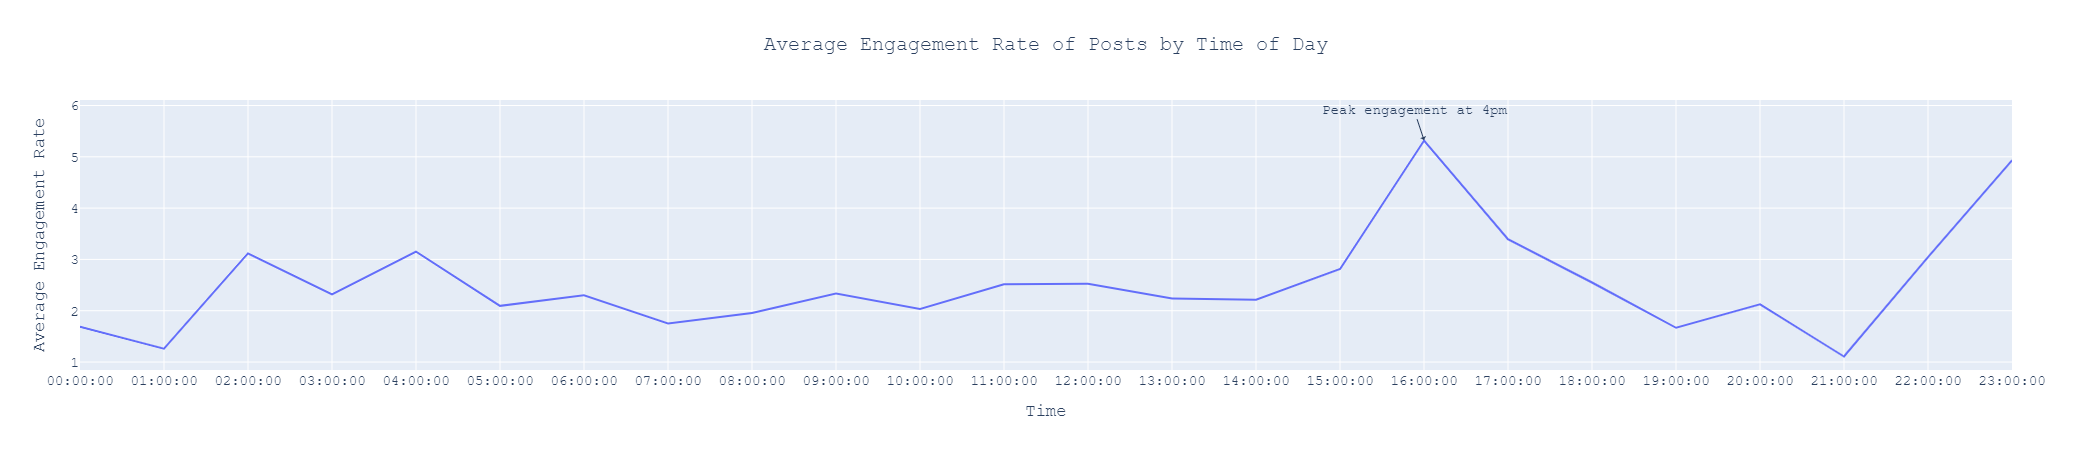

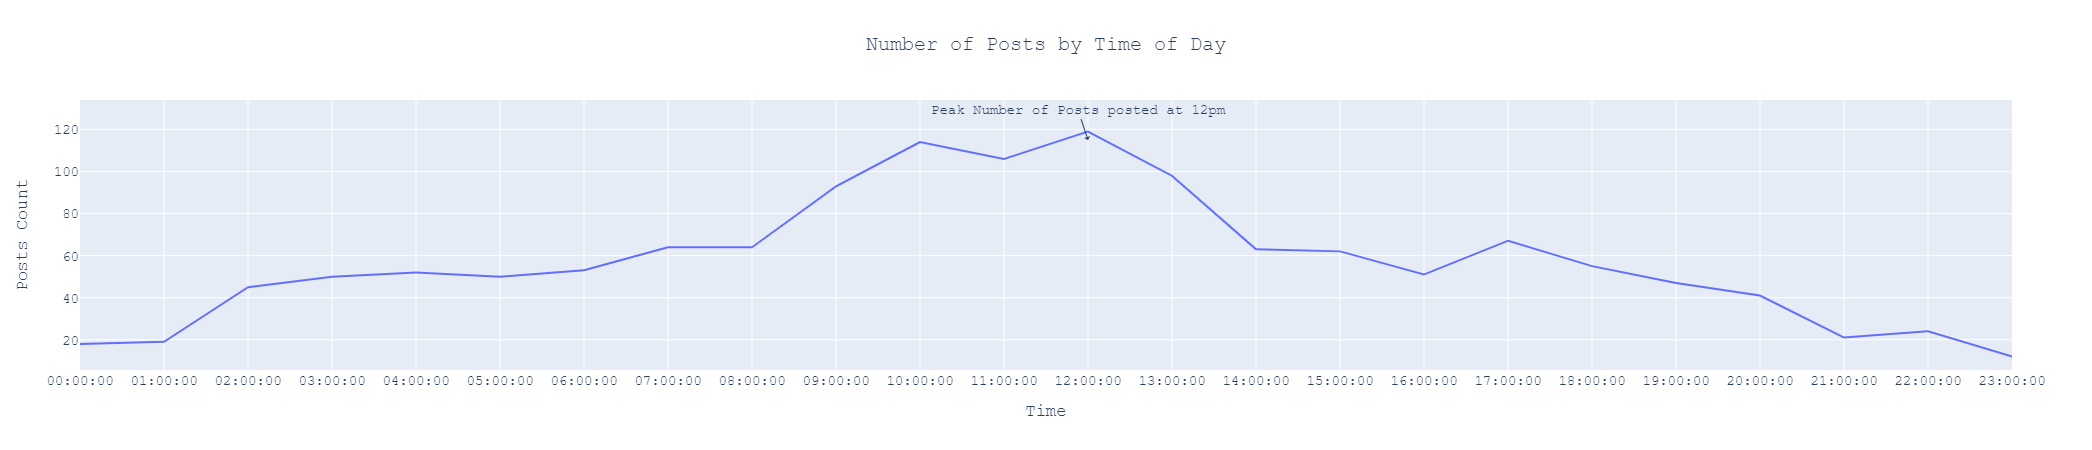

In [18]:
sponsored_df = inf_df[inf_df.Sponsored == 'Yes'] # Create Sponsored subset

avg_er = sponsored_df['Engagement Rate'].groupby(sponsored_df.index.floor('H').strftime('%H:%M:%S')).mean()
fig = go.Figure()
lineplot = fig.add_trace(go.Scatter(x=avg_er.index,y=avg_er))

fig.add_annotation(x='16:00:00', y=5.327327,
            text="Peak engagement at 4pm",
            showarrow=True,
            arrowhead=1).update_layout(
    title="Average Engagement Rate of Posts by Time of Day",title_x=0.5,
    xaxis_title="Time",
    yaxis_title="Average Engagement Rate",
    font=dict(
        family="Courier New, monospace",
        size=14,
    )
)
number_posts = sponsored_df['User'].groupby(sponsored_df.index.floor('H').strftime('%H:%M:%S')).count()
fig = go.Figure()
lineplot = fig.add_trace(go.Scatter(x=number_posts.index,y=number_posts))

fig.add_annotation(x='12:00:00', y=115,
            text="Peak Number of Posts posted at 12pm",
            showarrow=True,
            arrowhead=1).update_layout(
    title="Number of Posts by Time of Day",title_x=0.5,
    xaxis_title="Time",
    yaxis_title="Posts Count",
    font=dict(
        family="Courier New, monospace",
        size=14,
    )
)

**Frequency of Sponsorship by Brand**

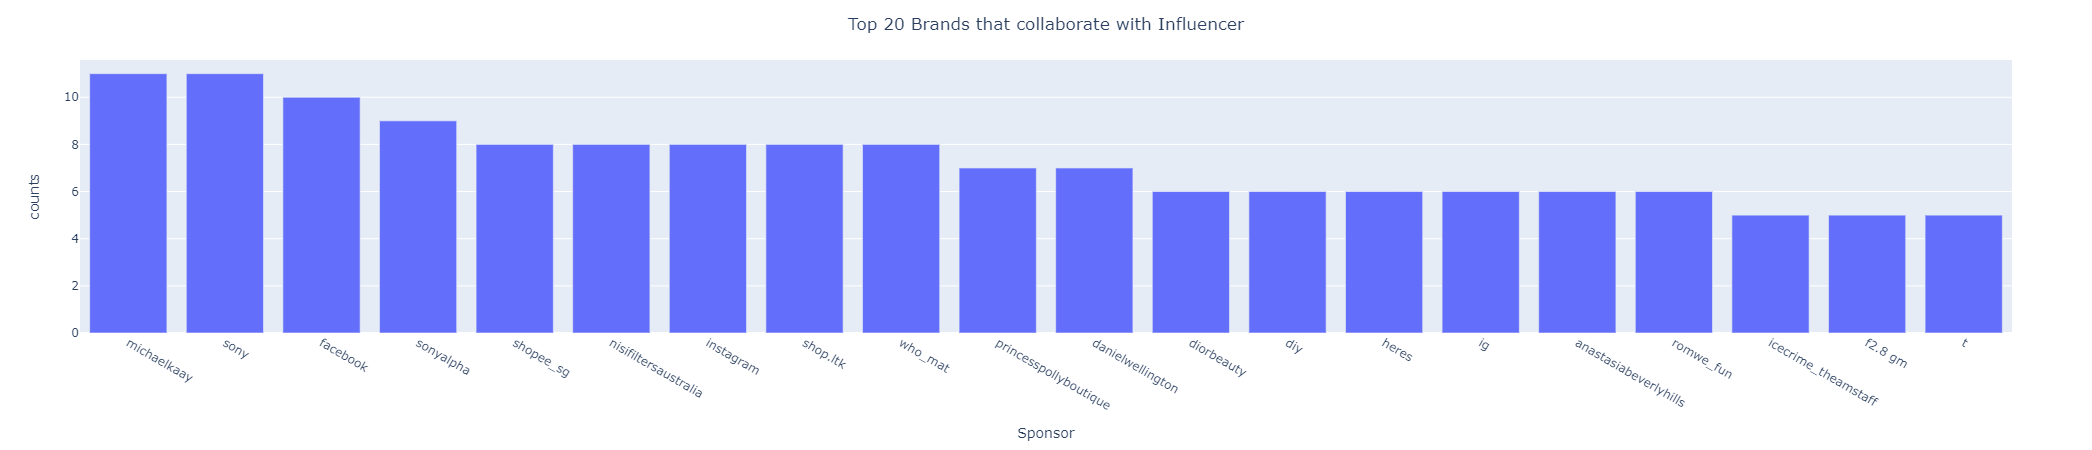

In [19]:
sponsor_frequency = pd.DataFrame(columns=['Sponsor','Engagement Rate'])

for index, row in sponsored_df[['Sponsor','Engagement Rate']].iterrows():
    for i in row['Sponsor']:
        text = i.replace('@',"")
        if text.isspace():
            continue
        else:
            sponsor_frequency = sponsor_frequency.append(pd.DataFrame({"Sponsor": [text],"Engagement Rate": [row['Engagement Rate']] }))

        
sponsor_frequency.reset_index(drop=True, inplace=True)
s = sponsor_frequency.groupby(['Sponsor']).size().reset_index(name='counts')
s = s.sort_values(by='counts', ascending=False)

fig = px.bar(s.head(20), x='Sponsor', y='counts')
fig.update_layout(title_text='Top 20 Brands that collaborate with Influencer', title_x=0.5)


**Country/Industry that has the most sponsorship**

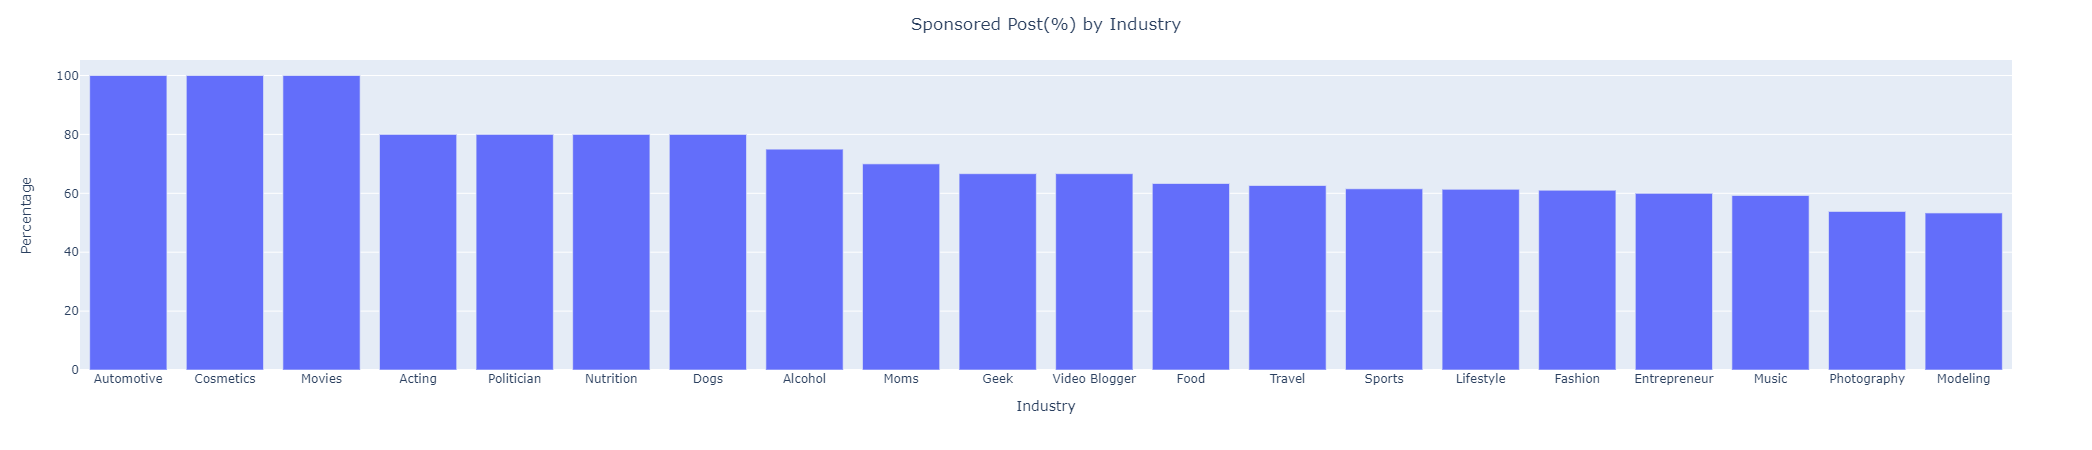

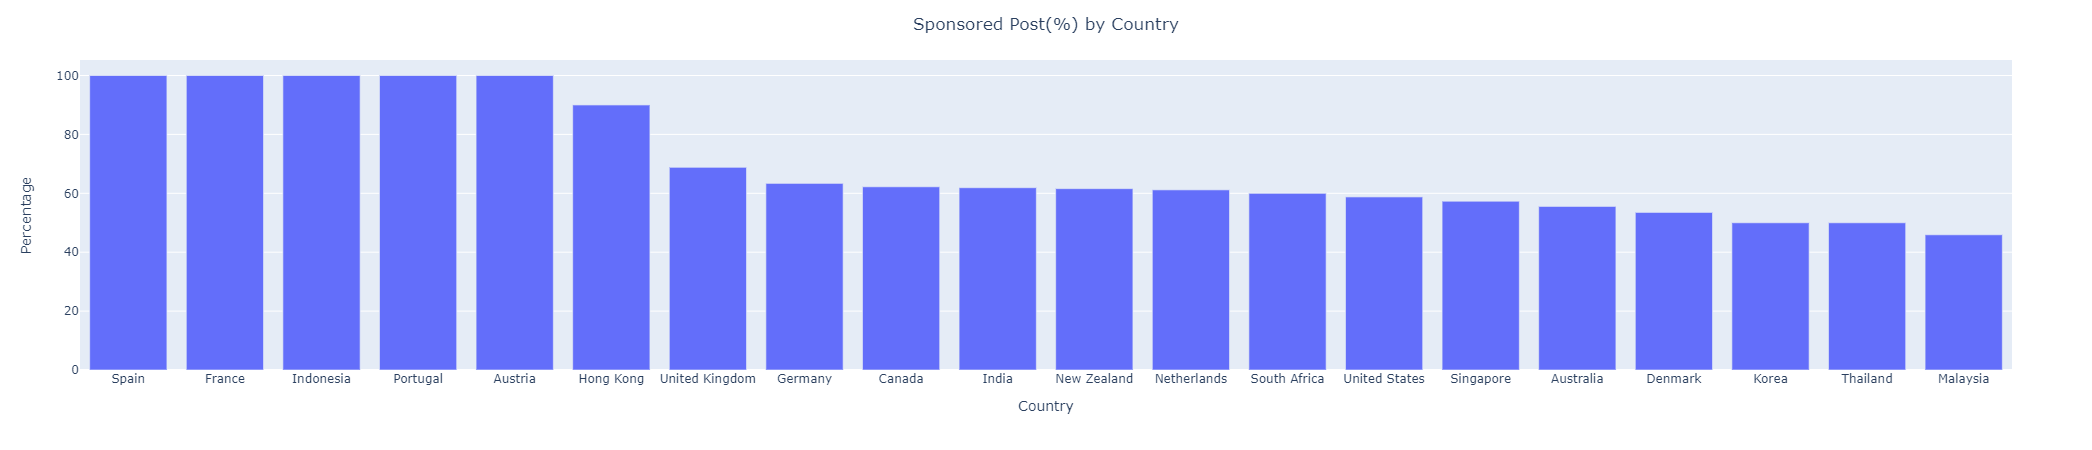

In [20]:
industry_sponsor_percentage = inf_df[['Industry','Sponsored']]
y = industry_sponsor_percentage.groupby(['Industry']).apply(lambda x: (x['Sponsored'] == "Yes").sum()).reset_index(name = 'Sponsored')
n = industry_sponsor_percentage.groupby(['Industry']).apply(lambda x: (x['Sponsored'] == "No").sum()).reset_index(name = 'NotSponsored')

industry_sponsor_percentage = y.merge(n, left_on='Industry', right_on='Industry')

industry_sponsor_percentage['Percentage'] =  industry_sponsor_percentage.apply(lambda row: (row.Sponsored / (row.Sponsored + row.NotSponsored))*100, axis=1)

industry_sponsor_percentage = industry_sponsor_percentage.sort_values(by='Percentage', ascending=False)
fig = px.bar(industry_sponsor_percentage.head(20), x='Industry', y='Percentage')
fig.update_layout(title_text='Sponsored Post(%) by Industry', title_x=0.5)
#################################################################################################################################################################

country_sponsor_percentage = inf_df[['Country','Sponsored']]
y = country_sponsor_percentage.groupby(['Country']).apply(lambda x: (x['Sponsored'] == "Yes").sum()).reset_index(name = 'Sponsored')
n = country_sponsor_percentage.groupby(['Country']).apply(lambda x: (x['Sponsored'] == "No").sum()).reset_index(name = 'NotSponsored')

country_sponsor_percentage = y.merge(n, left_on='Country', right_on='Country')

country_sponsor_percentage['Percentage'] =  country_sponsor_percentage.apply(lambda row: (row.Sponsored / (row.Sponsored + row.NotSponsored))*100, axis=1)

country_sponsor_percentage = country_sponsor_percentage.sort_values(by='Percentage', ascending=False)
fig = px.bar(country_sponsor_percentage.head(20), x='Country', y='Percentage')
fig.update_layout(title_text='Sponsored Post(%) by Country', title_x=0.5)